# HFT Research For Dummies

A How To Guide On Doing HFT Research

Reference: https://www.algos.org/p/hft-research-for-dummies?publication_id=1392884

## Introduction

Today, I’ll talk about some general functions and activities in HFT research. It’s not an all encompassing guide by any means, but this tooling should end up being useful for you in your research endeavours. Certainly these are common tasks I have encountered.

## Index

1. Introduction
2. Index
3. Orderbook Impacts   
   a. SnapShot    
   b. Incremental    
4. Latency Analysis

### Orderbook Impacts - Snapshot

Usually we just need to find out whether the strategy works in the first place and we infer the capacity from the liquidity of the assets we trade, but in other occasions we need to figure out the impact of a certain size on the orderbook (or otherwise use this data to find the capacity of the strategy itself).    

We’ll use tardis.dev data to do this, with the formats shown below, of which book_snapshot_25 will be out data type of use today: 

Let’s start by pulling some orderbook data for ETHUSDT on Bybit:

In [1]:
import asyncio
import requests
import nest_asyncio
import json

In [2]:
import pandas as pd

In [32]:
import matplotlib.pyplot as plt

Fontconfig warning: "/usr/local/etc/fonts/fonts.conf", line 86: unknown element "blank"
Matplotlib is building the font cache; this may take a moment.


In [3]:
import ccxt

In [4]:
from urllib import parse

In [5]:
from tardis_dev import datasets
from tqdm import tqdm

In [6]:
exchange_name = "bybit"
symbol = "ETHUSDT"
dtype="book_snapshot_25"
start_date = "2024-01-01"
end_date = "2024-01-03"

download from ccxt instead of tradis_dev

In [7]:
# ccxt를 이용하여 Binance 거래소에 접속
exchange = ccxt.binance()

# ETH/USDT의 order book 가져오기
symbol = 'ETH/USDT'

def fetch_order_book(symbol):
    try:
        # Binance에서 order book 데이터 가져오기
        order_book = exchange.fetch_order_book(symbol)
        
        # 데이터를 출력 (혹은 원하는 방식으로 처리)
        print(f"Timestamp: {order_book['timestamp']}")
        print(f"Bids (Price, Amount): {order_book['bids'][:5]}")  # 상위 5개 매수 내역
        print(f"Asks (Price, Amount): {order_book['asks'][:5]}")  # 상위 5개 매도 내역
        return order_book

    except Exception as e:
        print(f"Error fetching order book: {str(e)}")

# 실행
order_book = fetch_order_book(symbol)


Timestamp: None
Bids (Price, Amount): [[2432.85, 32.9998], [2432.83, 1.9973], [2432.82, 3.9006], [2432.81, 0.003], [2432.8, 2.741]]
Asks (Price, Amount): [[2432.86, 5.5796], [2432.87, 0.0021], [2432.88, 0.28], [2432.89, 0.0021], [2432.9, 0.0408]]


In [8]:
bids = pd.DataFrame(order_book['bids'], columns=['price', 'qty'])
asks = pd.DataFrame(order_book['asks'], columns=['price', 'qty']).sort_values('price', ascending=True)

In [9]:
bids.head()

,price,qty
0,2432.85,32.9998
1,2432.83,1.9973
2,2432.82,3.9006
3,2432.81,0.0030
4,2432.80,2.7410


In [10]:
asks.head()

,price,qty
0,2432.86,5.5796
1,2432.87,0.0021
2,2432.88,0.2800
3,2432.89,0.0021
4,2432.90,0.0408


In [11]:
midprice = (bids.iloc[0]['price'] + asks.iloc[0]['price']) / 2

Anyways, we often need to find out the impact of our trades at a given timestamp, so hence we can use the below code to calculate the impact in bps:

In [12]:
# original code
def calculate_impact(row: pd.Series, order_size: float, side: str = 'buy') -> (str, str):
    bids = [(row[f'bids[{i}].price'], row[f'bids[{i}].amount']) for i in range(25)]
    asks = [(row[f'asks[{i}].price'], row[f'asks[{i}].amount']) for i in range(25)]
    
    bids = sorted(bids, key=lambda x: x[0], reverse=True)
    asks = sorted(asks, key=lambda x: x[0])
    
    midprice = (bids[0][0] + asks[0][0]) / 2
    
    remaining_size = order_size
    weighted_price = 0
    
    if side == 'buy':
        for price, amount in asks:
            if remaining_size <= 0:
                break
            filled = min(remaining_size, amount)
            weighted_price += price * filled
            remaining_size -= filled
    else:  # sell
        for price, amount in bids:
            if remaining_size <= 0:
                break
            filled = min(remaining_size, amount)
            weighted_price += price * filled
            remaining_size -= filled
    
    avg_price = weighted_price / (order_size - remaining_size)
    impact_bps = abs(avg_price - midprice) / midprice * 10000
    
    return impact_bps, remaining_size

In [13]:
# twisted code
def calculate_impact_v2(bids: pd.DataFrame, asks: pd.DataFrame, order_size: float, side: str = 'buy') -> (str, str):
    # bids = [(row[f'bids[{i}].price'], row[f'bids[{i}].amount']) for i in range(25)]
    # asks = [(row[f'asks[{i}].price'], row[f'asks[{i}].amount']) for i in range(25)]
    
    # bids = sorted(bids, key=lambda x: x[0], reverse=True)
    # asks = sorted(asks, key=lambda x: x[0])
    
    midprice = (bids.iloc[0]['price'] + asks.iloc[0]['price']) / 2
    
    remaining_size = order_size
    weighted_price = 0
    
    if side == 'buy':
        for row in asks.iterrows():
            price = row[1]['price']
            amount = row[1]['qty']
            if remaining_size <= 0:
                break
            filled = min(remaining_size, amount)
            weighted_price += price * filled
            remaining_size -= filled
    else:  # sell
        for row in asks.iterrows():
            price = row[1]['price']
            amount = row[1]['qty']
            if remaining_size <= 0:
                break
            filled = min(remaining_size, amount)
            weighted_price += price * filled
            remaining_size -= filled
    
    avg_price = weighted_price / (order_size - remaining_size)
    impact_bps = abs(avg_price - midprice) / midprice * 10000
    
    return impact_bps, remaining_size

In [14]:
order_size = 300
side = 'buy'

In [15]:
result = calculate_impact_v2(bids, asks, order_size, side)

In [16]:
result

(np.float64(3.201563745746708), np.float64(0.0))

At this point, we can either use the empirical data and then extrapolate from there by fitting a square root law:

In [17]:
import numpy as np
from scipy.optimize import curve_fit

In [18]:
# original code
def calculate_impact_at_sizes(row, sizes, side='buy'):
    bids = [(row[f'bids[{i}].price'], row[f'bids[{i}].amount']) for i in range(25)]
    asks = [(row[f'asks[{i}].price'], row[f'asks[{i}].amount']) for i in range(25)]
    
    bids = sorted(bids, key=lambda x: x[0], reverse=True)
    asks = sorted(asks, key=lambda x: x[0])
    
    midprice = (bids[0][0] + asks[0][0]) / 2
    
    impacts = []
    for size in sizes:
        remaining_size = size
        weighted_price = 0
        
        if side == 'buy':
            for price, amount in asks:
                if remaining_size <= 0:
                    break
                filled = min(remaining_size, amount)
                weighted_price += price * filled
                remaining_size -= filled
        else:  # sell
            for price, amount in bids:
                if remaining_size <= 0:
                    break
                filled = min(remaining_size, amount)
                weighted_price += price * filled
                remaining_size -= filled
        
        if size - remaining_size == 0:
            impacts.append(0)  # Not enough liquidity
        else:
            avg_price = weighted_price / (size - remaining_size)
            impact_bps = abs(avg_price - midprice) / midprice * 10000
            impacts.append(impact_bps)
    
    return np.array(impacts)  

def power_law(x, a, b):
    return a * np.power(x, b)

def estimate_impact_model(row, side='buy'):
    sizes = np.logspace(0, 4, num=20)  # Adjust as necessary otherwise you'll have sizing tune issues
    impacts = calculate_impact_at_sizes(row, sizes, side)
    
    valid_mask = impacts > 0 # Filter out zero impacts
    valid_sizes = sizes[valid_mask]
    valid_impacts = impacts[valid_mask]
    
    if len(valid_sizes) < 2:
        return None, None  
    
    # Fit the power law
    popt, _ = curve_fit(power_law, valid_sizes, valid_impacts, p0=[1, 0.5], bounds=([0, 0], [np.inf, 1]))
    a, b = popt
    
    return a, b

def predict_impact(size, a, b):
    return power_law(size, a, b)

In [19]:
# twisted code
def calculate_impact_at_sizes_v2(bids: pd.DataFrame, asks: pd.DataFrame, sizes, side='buy'):
    # bids = [(row[f'bids[{i}].price'], row[f'bids[{i}].amount']) for i in range(25)]
    # asks = [(row[f'asks[{i}].price'], row[f'asks[{i}].amount']) for i in range(25)]
    
    # bids = sorted(bids, key=lambda x: x[0], reverse=True)
    # asks = sorted(asks, key=lambda x: x[0])
    
    # midprice = (bids[0][0] + asks[0][0]) / 2

    midprice = (bids.iloc[0]['price'] + asks.iloc[0]['price']) / 2
    
    remaining_size = order_size
    weighted_price = 0
    
    impacts = []
    for size in sizes:
        remaining_size = size     # 주문 수량을 remaining_size 에 저장
        weighted_price = 0
        
        if side == 'buy':
            for row in asks.iterrows():
                price = row[1]['price']
                amount = row[1]['qty']
                if remaining_size <= 0:
                    break
                filled = min(remaining_size, amount)    # 호가잔량 (amount) 만큼 채결수량 (filled) 계산
                weighted_price += price * filled        # 채결 수량 x 매도 호가 값을 가중 가격 값에 합산
                remaining_size -= filled                # 남아 있는 주문수량에서 채결 수량 제거
        elif side == 'sell':  # sell
            for row in bids.iterrows():
                price = row[1]['price']
                amount = row[1]['qty']
                if remaining_size <= 0:
                    break
                filled = min(remaining_size, amount)    # 호가잔량 (amount) 만큼 채결수량 (filled) 계산
                weighted_price += price * filled        # 채결 수량 x 매도 호가 = 가중 가격
                remaining_size -= filled                # 남아 있는 주문수량에서 채결 수량 제거
        
        if size - remaining_size == 0:                  # 주문수량 과 남아 있는 주문수량 값이 같으면 유동성 부족으로 등록
            impacts.append(0)  # Not enough liquidity   
        else:
            avg_price = weighted_price / (size - remaining_size)   # 평균가격 = 가중가격합산 (sum(price x filled)) / 총체결수량 
            impact_bps = abs(avg_price - midprice) / midprice * 10000  # market impact 계산 (https://en.wikipedia.org/wiki/Market_impact)
            impacts.append(impact_bps)
    
    return np.array(impacts)

In [20]:
# twisted code
def estimate_impact_model_v2(bids: pd.DataFrame, asks: pd.DataFrame, side='buy'):
    sizes = np.logspace(0, 4, num=20)  # Adjust as necessary otherwise you'll have sizing tune issues
    impacts = calculate_impact_at_sizes_v2(bids, asks, sizes, side)
    
    valid_mask = impacts > 0 # Filter out zero impacts
    valid_sizes = sizes[valid_mask]
    valid_impacts = impacts[valid_mask]
    
    if len(valid_sizes) < 2:
        return None, None  
    
    # Fit the power law
    popt, _ = curve_fit(power_law, valid_sizes, valid_impacts, p0=[1, 0.5], bounds=([0, 0], [np.inf, 1]))
    a, b = popt
    
    return a, b

In [21]:
sizes = np.logspace(0, 4, num=20)

In [34]:
sizes

array([1.00000000e+00, 1.62377674e+00, 2.63665090e+00, 4.28133240e+00,
       6.95192796e+00, 1.12883789e+01, 1.83298071e+01, 2.97635144e+01,
       4.83293024e+01, 7.84759970e+01, 1.27427499e+02, 2.06913808e+02,
       3.35981829e+02, 5.45559478e+02, 8.85866790e+02, 1.43844989e+03,
       2.33572147e+03, 3.79269019e+03, 6.15848211e+03, 1.00000000e+04])

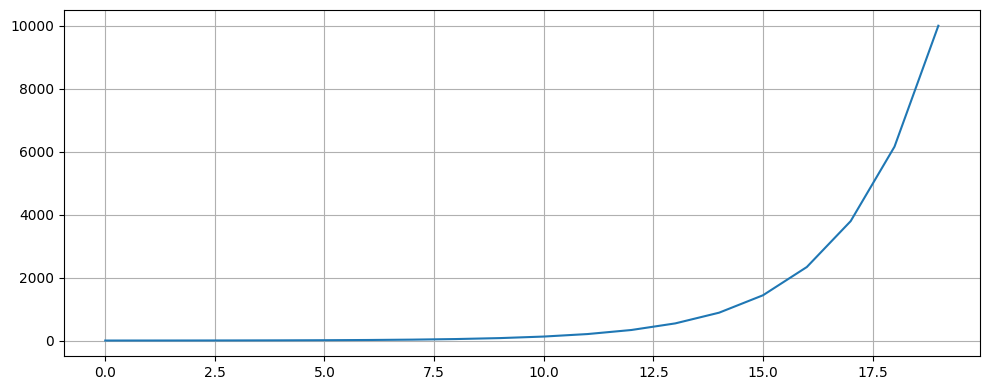

In [36]:
plt.figure(figsize=(10, 4))  # 그래프 크기 설정
plt.plot(sizes)
plt.grid(True)  # 그리드 추가
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

In [37]:
impacts = calculate_impact_at_sizes_v2(bids, asks, sizes, 'buy')

In [40]:
impacts

array([0.02055199, 0.02055199, 0.02055199, 0.02055199, 0.11836152,
       0.42950402, 0.82828035, 1.18052574, 1.51204109, 1.86300941,
       2.29439652, 2.76795788, 3.37338909, 4.3601763 , 4.3601763 ,
       4.3601763 , 4.3601763 , 4.3601763 , 4.3601763 , 4.3601763 ])

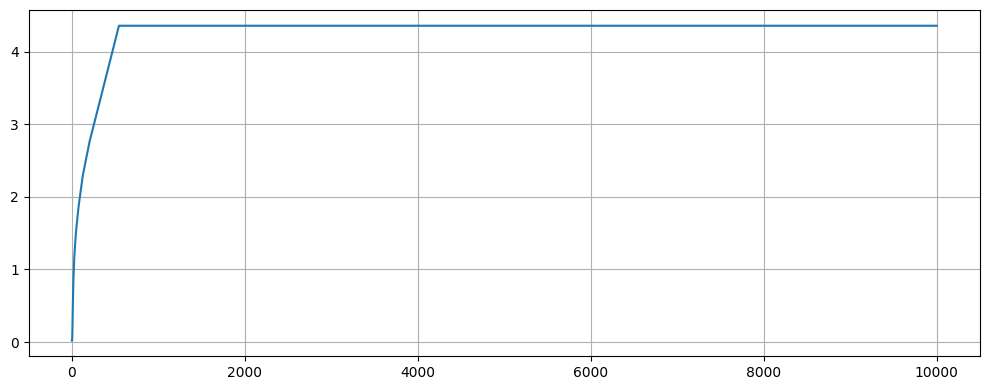

In [39]:
plt.figure(figsize=(10, 4))  # 그래프 크기 설정
plt.plot(sizes, impacts)
plt.grid(True)  # 그리드 추가
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

In [22]:
a_buy, b_buy = estimate_impact_model_v2(bids, asks, 'buy')
if a_buy is not None:
    print(f"Buy Model: Impact = {a_buy:.4f} * size^{b_buy:.4f}")
    large_size = 300
    predicted_impact = predict_impact(large_size, a_buy, b_buy)
    print(f"Predicted buy impact for size {large_size}: {predicted_impact:.2f} bps")

Buy Model: Impact = 0.6669 * size^0.2308
Predicted buy impact for size 300: 2.49 bps


In [23]:
a_sell, b_sell = estimate_impact_model_v2(bids, asks, 'sell')
if a_sell is not None:
    print(f"Sell Model: Impact = {a_sell:.4f} * size^{b_sell:.4f}")
    large_size = 300
    predicted_impact = predict_impact(large_size, a_sell, b_sell)
    print(f"Predicted sell impact for size {large_size}: {predicted_impact:.2f} bps")

Sell Model: Impact = 0.3246 * size^0.2952
Predicted sell impact for size 300: 1.75 bps


You can also use the standard sqrt law rule, that's pretty accurate… or tune over a much longer horizon. I won’t go into this too much; it’s a dirty fix for when we don’t want to reconstruct the book on a live basis… which brings us to the next section.

## Orderbook Impacts - Incremental

There are a few reasons to prefer the use of incremental orderbook data over snapshot data:

1. It’s far smaller to store on the disk because it avoids duplication.
2. It comes from a feed that is typically slightly faster and would be the one used in production.
3. It shows much more levels than the snapshot, allowing us to gauge the impact of greater sizes.

Continuing from our previous data scraping, we’ll be using Tardis with the same symbol and exchange:

In [41]:
# original code
dtype = "incremental_book_L2"

# Loop through available exchanges
for exchange_name in [exchange_name]:
    # Loop through base tickers
    for current_data_type in [dtype]:
        # Normalizing Ticker Names Based On Exchange
        current_symbol = symbol
        
        # Some tickers will not be available so are caught with an error
        try:
            datasets.download(
                exchange=exchange_name,
                data_types=[
                    current_data_type
                ],
                from_date=start_date,
                to_date=end_date,
                symbols=[
                    current_symbol
                ],
                download_dir=f"D:/Market_Data/Digital_Assets/Tardis_Data/{exchange_name}/Futures/{current_symbol}/{current_data_type}",
                api_key=tardis_api_key,
            )
        except Exception as e:
            pass

We can then go and build code to transform it into snapshots, but generated live. This is simply an orderbook problem - which I won’t get into here, but you can find many examples on GitHub. Often a BTree is used, but everyone has their own approach which balances the cost of inserts, reads, etc. 

You can also use the Tardis Machine which replays the market via a normalized format historically, but can also be switched to live mode where it aggregates feeds behind the scenes. **It is like CCXT - but better. The live version is also free.**

## Latency Analysis

When it comes to HFT strategies, you often reach a point where latency cannot be ignored. Simply having great alphas and modelling is not enough—you also need to be competitive on the latency front. Most of this is concentrated on the cloud network engineering front, so let’s implement some practical experiments, ones that would typically be performed inside of top-tier firms’ latency research operations, to develop optimal network setups.

### Why network latency is key

Let’s start by assuming a normal distribution for latency — it isn’t and has quite the extreme tail, but this would only serve to further help our argument, so it doesn't matter much.

We start by simulating a quick scenario. Given some reasonable network latency assumptions for a volatile market, how often does someone with 1ms latency beat someone with 10us latency? It’s pretty clear that the improvement is quite minimal if we have 1ms compute latency vs. 10us compute latency. 

In [44]:
import numpy as np

# Parameter
mean_network_latency = 30     # Mean Network latency in milliseconds
std_network_latency = 20      # Standard deviation of network latency in millliseconds
compute_latency_1 = 1             # Compute latency for scenario 1 in milliseconds
compute_latency_2 = 0.01          # Compute latency for scenario 2 in milliseconds
n_simulations = 1_000_000         # Number of simulations

# Simulate network latencies
network_latencies_1 = np.random.normal(mean_network_latency, std_network_latency, n_simulations)
network_latencies_2 = np.random.normal(mean_network_latency, std_network_latency, n_simulations)

# Calculate total latencies for both scenarios
total_latency_1 = network_latencies_1 + compute_latency_1
total_latency_2 = network_latencies_2 + compute_latency_2

# Calculate how often total_latency_1 is less than total_latency_2
count_1_beats_2 = np.sum(total_latency_1 < total_latency_2)

# Calculate the percentage
percentage_1_beats_2 = (count_1_beats_2 / n_simulations) * 100

percentage_1_beats_2

np.float64(48.5835)

**Network latency can shoot up to hundreds of milliseconds in extreme scenarios**, so having optimized network setups can keep your latency within normal ranges during this. This gives you an extraordinary edge that is practically impossible to beat with any sort of computing edge.

Now, we’d be in a rough position if we had 10ms compute latency, so if you are latency-concerned, you will want to be using Rust or C++, but you won’t be doing complex optimizations of your code like in equities. Instead, you will be doing complex optimizations of your network, which we’ll cover in this article. 

### How to Record Latency (Correctly)

In [24]:
import time
from ping3 import ping, verbose_ping

In [25]:
# Binance domain to ping
binance_domain = 'www.binance.com'

In [26]:
# Perform a single ping and record the latency
latency = ping(binance_domain)

In [27]:
# Check if latency is None (meaning the ping failed)
if latency is not None:
    print(f"Latency to {binance_domain}: {latency * 1000:.2f} ms")
else:
    print(f"Ping to {binance_domain} failed")

Latency to www.binance.com: 4.41 ms


In [28]:
# You can also record multiple pings for more accurate measurement
latencies = []
for _ in range(5):
    latency = ping(binance_domain)
    if latency is not None:
        latencies.append(latency)
    time.sleep(1)

In [29]:
if latencies:
    average_latency = sum(latencies) / len(latencies)
    print(f"Average latency to {binance_domain}: {average_latency * 1000:.2f} ms")
else:
    print("All pings failed")

Average latency to www.binance.com: 5.62 ms
